# Propensity Score Matching

In this notebook, we use the kaggle Titanic dataset to demonstrate the process of propensity score matching. The main goal is to estimate the effect of a treatment (the passager has a cabin) on the final survival status. As we know, it is not Randomised Controlled Testing (i.e. A/B testing). 

In [ ]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import math 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)}, font_scale=1.3)

In [ ]:
# Enabled to remove warnings for demo purposes.
import warnings
warnings.filterwarnings('ignore')

### Define some utils functions

In [ ]:

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value
   
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [ ]:
df = pd.read_csv('https://grantmlong.com/data/titanic.csv')
# Elements are dropped for simplicity.
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()


1. Create an artificial treatment effect. It is based on the condition that a passenger has a cabin (1) or not (0).

2. The outcome here is the status of Survived

In [ ]:
df = pd.read_csv('https://grantmlong.com/data/titanic.csv')
# Elements are dropped for simplicity.
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()
def hasCabin(x):
    if pd.isna(x):
        return 0
    else:
        return 1
df['treatment'] = df.Cabin.apply(hasCabin)

In [ ]:
overview = df[['Survived','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)
treated_outcome = overview['Survived']['mean'][1]
control_outcome = overview['Survived']['mean'][0]

           Survived                          
               mean       var       std count
treatment                                    
0          0.311909  0.215028  0.463712   529
1          0.672131  0.221582  0.470725   183


In [ ]:
print("the survival rate between control and treatment group is {}".format(treated_outcome - control_outcome))

the survival rate between control and treatment group is 0.3602218847810592


In [ ]:
from scipy import stats
treated_outcome = treated_matched_data.outcome
untreated_outcome = untreated_matched_data.outcome
stats_results = stats.ttest_ind(treated_outcome, untreated_outcome)

In [ ]:
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

#### There is high correlation between treatment (i.e. hasCabin) and Class. And somehow the factor class also impacts the outcome. This is called confounding factors.

In [ ]:
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,26,158,345
1,158,15,10


#### Let us try to account for our confounding factors. 

Propensity model is to predict the treatment based on confounding factors.

In [ ]:
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]

In [ ]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [ ]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [ ]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('feature_scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('feature_scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [ ]:
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)

In [ ]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))

Accuracy: 0.9284

Confusion matrix:
[[503  26]
 [ 25 158]]

F1 score is: 0.8610


In [ ]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

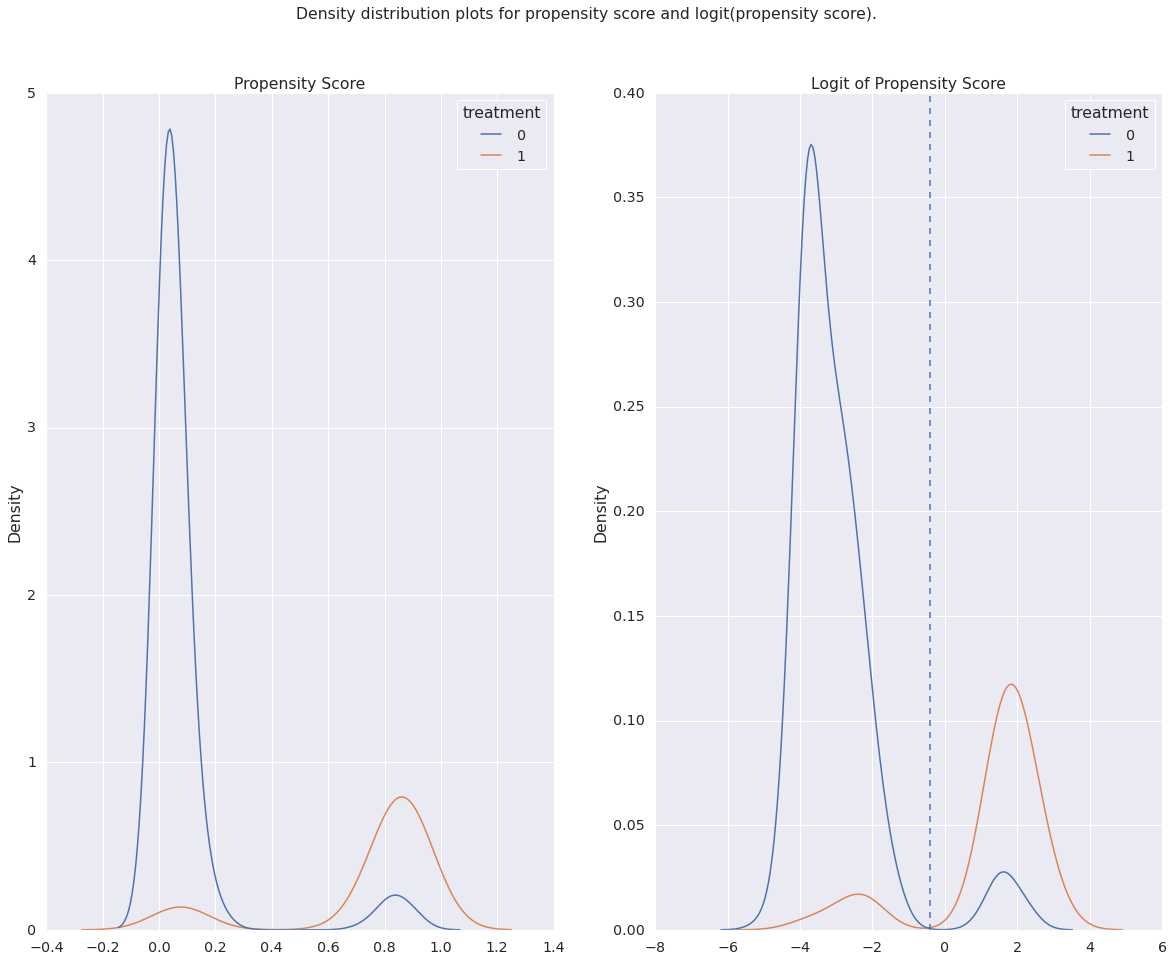

In [ ]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

If we look at the logit of propensity score, there is overlap accross the range of values (-6,5). However on the left (negative), there are a lot more 0's than 1's. On the right side (positive), the opposite is true (a lot more 1's than 0's).

In [ ]:
# Currently this does not affect the results as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [ ]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

### Matching Implementation

Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).

Caliper: 25% of standart deviation of logit(propensity score)

In [ ]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(n_neighbors=10, radius=0.08890268148266275)

In [ ]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [ ]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000021
Element distance: 0.001106
Element distance: 0.004490
...


In [ ]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 0
Element index: 607
Element index: 539
Element index: 301
...


In [ ]:
def perfom_matching(row, indexes, df_data):
    """
    For each sample in the treatment group, the cloest data sample in control group will be matched
    """
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    if row.treatment == 0:
      return None
    else:
      for idx in indexes[current_index,:]: 
        if df_data.loc[idx].treatment == 0: # for the tretment
            return int(idx)
         
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching, axis = 1, args = (indexes, df_data))

In [ ]:
df_data.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0.021156,-3.834463,0,0,NaN
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1,62.0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0.039982,-3.178512,1,0,NaN
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1,306.0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0.019913,-3.896294,0,0,NaN


### Get the samples in the treatment groups who have been assigned with matched control samples

In [ ]:
treated_with_match = ~df_data.matched_element.isna()
treated_matched_data = df_data[treated_with_match][df_data.columns]
treated_matched_data.head(3)

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1,62.0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1,306.0
5,54.0,0,0,51.8625,0,1,0,0,1,1,0,0,0.805110,1.418544,0,1,372.0


### Get the above matched control samples

In [ ]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = ['Age', 'SibSp', 'Parch', 'Fare', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'class_1', 'class_2', 'class_3',
       'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df_data, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')
untreated_matched_data.head(3)

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
matched_element,,,,,,,,,,,,,,,,
62.0,28.0,0.0,0.0,47.10,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.866278,1.868444,0.0,0.0
306.0,35.0,1.0,0.0,52.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.895251,2.145533,1.0,0.0
372.0,56.0,0.0,0.0,26.55,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.805278,1.419613,0.0,0.0


In [ ]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])

In [ ]:
all_mached_data.treatment.value_counts() # one to one pair

1.0    143
0.0    143
Name: treatment, dtype: int64

### Matching Review

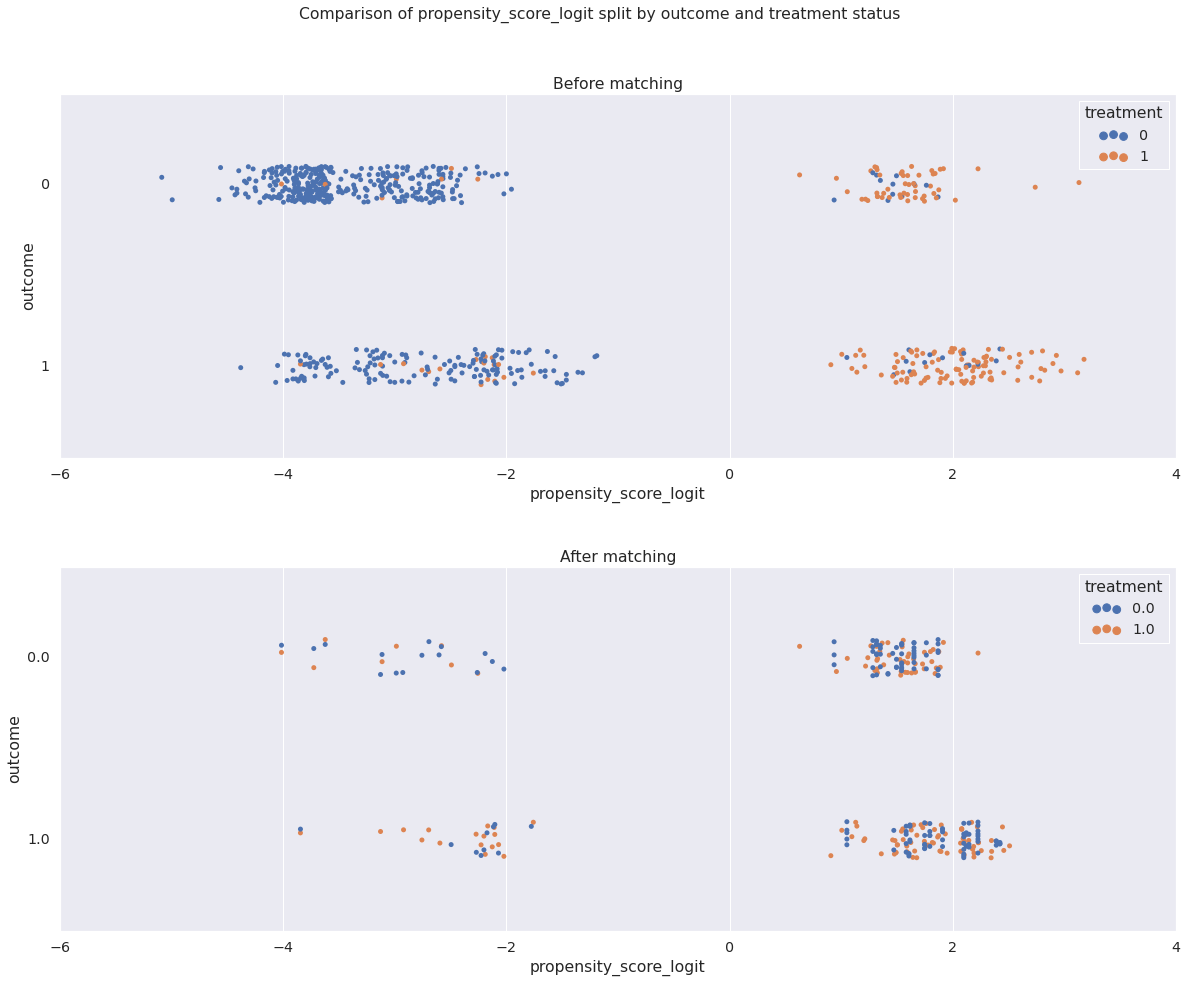

In [ ]:
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = df_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = all_mached_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()

In [ ]:
all_mached_data.reset_index(inplace=True)

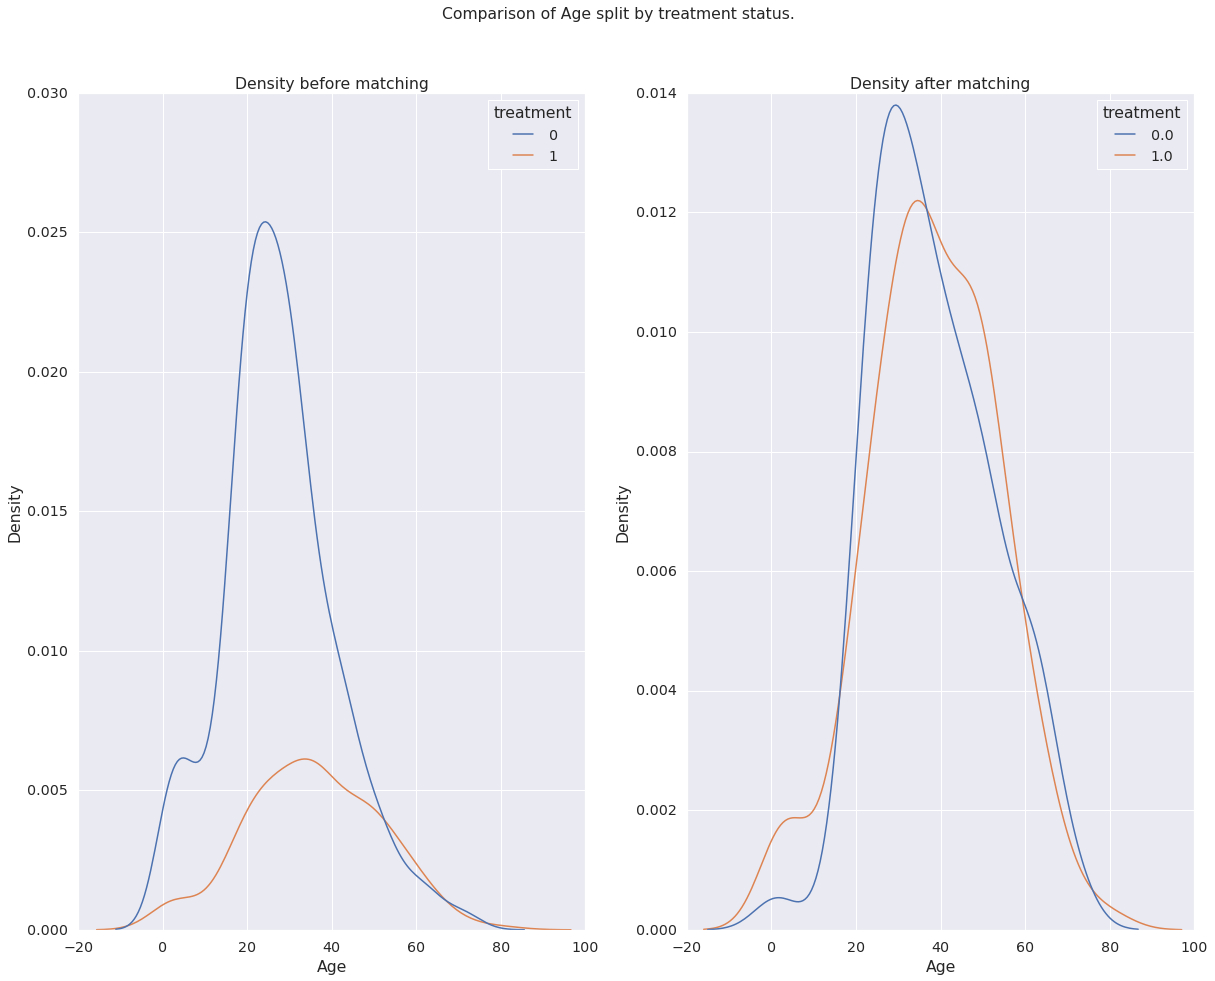

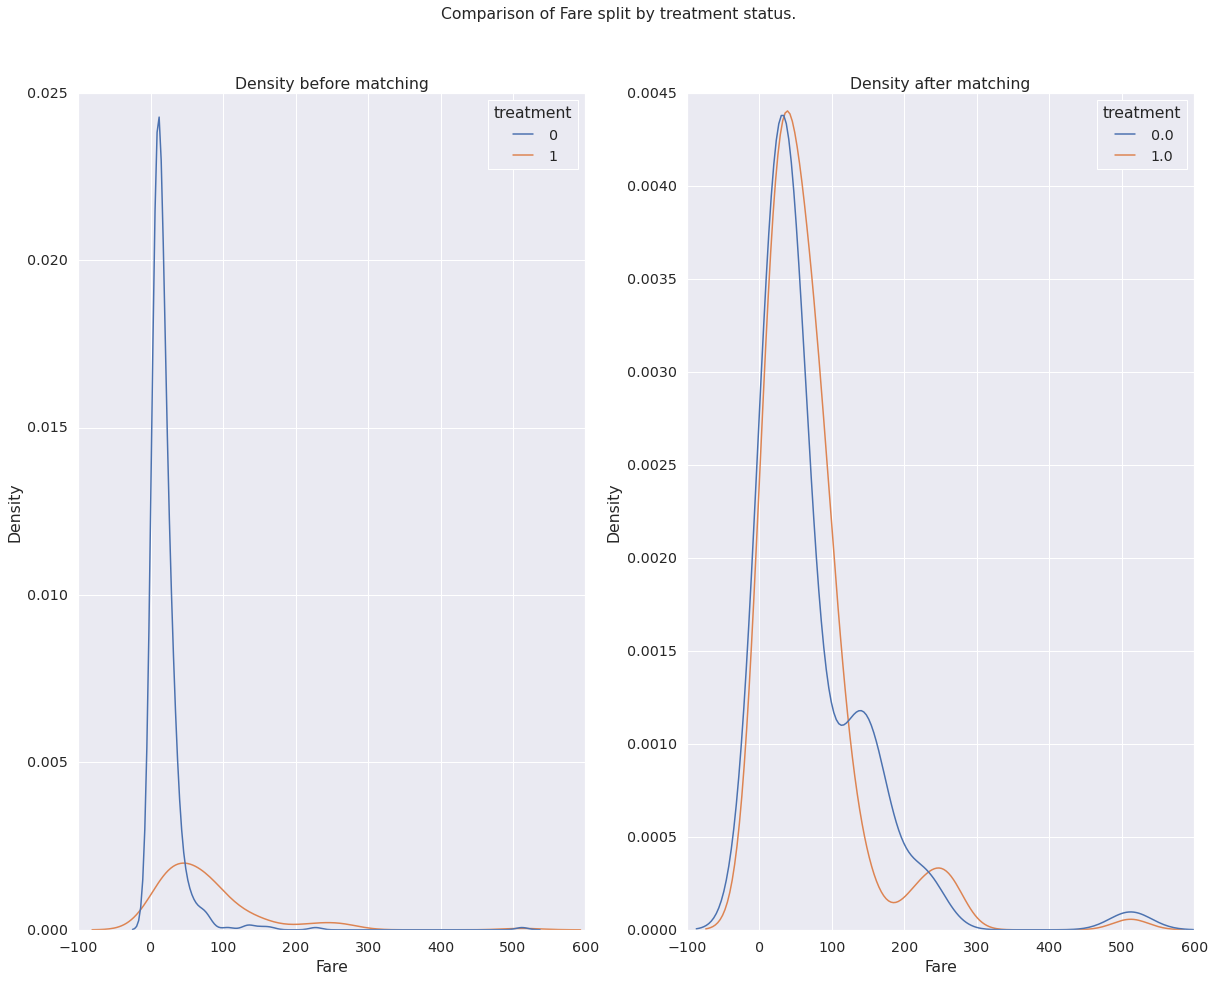

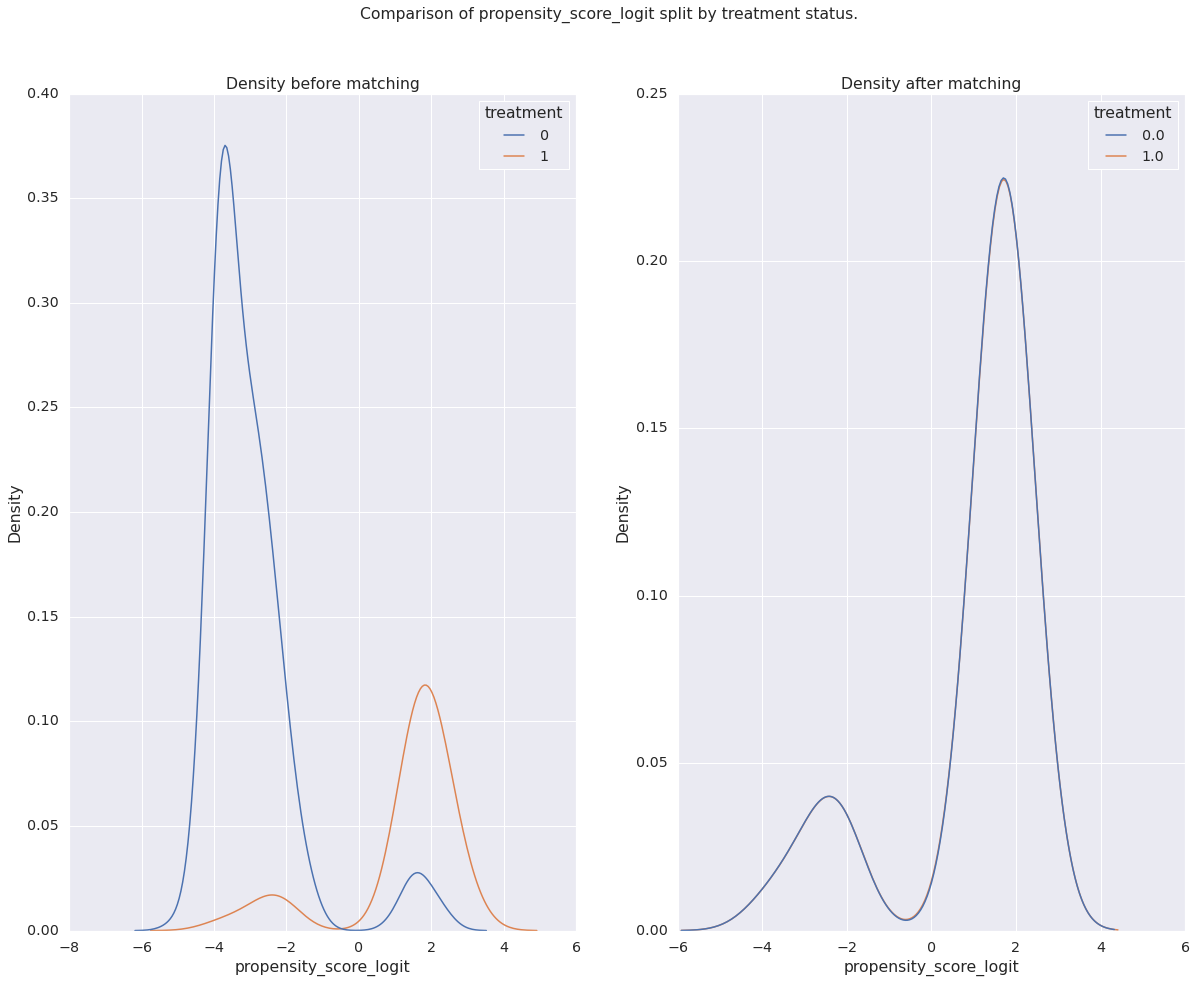

In [ ]:
args = ['Age','Fare','propensity_score_logit']

def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = df_data, x = arg, hue = 'treatment', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = all_mached_data, x = arg, hue = 'treatment',  ax = ax[1]).set(title='Density after matching')
    plt.show()

for arg in args:
    plot(arg)

### Average Treatment Effects

In [ ]:
overview = all_mached_data[['outcome','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

            outcome                          
               mean       var       std count
treatment                                    
0.0        0.517483  0.251453  0.501451   143
1.0        0.622378  0.236679  0.486496   143


In [ ]:
treated_outcome = overview['outcome']['mean'][1]
treated_counterfactual_outcome = overview['outcome']['mean'][0]

In [ ]:
att = treated_outcome - treated_counterfactual_outcome
print('The Average Treatment Effect (ATT): {:.4f}'.format(att))

The Average Treatment Effect (ATT): 0.1049


We could also run some quick hypothesis testing

In [ ]:
from scipy import stats
treated_outcome = treated_matched_data.outcome
untreated_outcome = untreated_matched_data.outcome
stats_results = stats.ttest_ind(treated_outcome, untreated_outcome)

In [ ]:
print(stats_results)

Ttest_indResult(statistic=1.7953733922038098, pvalue=0.07365728441041221)
